## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [6]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

In [7]:
import copy
import numpy as np

from pydrake.common.containers import namedview
from pydrake.systems.framework import (BasicVector, LeafSystem, PublishEvent,
                                       PortDataType, UnrestrictedUpdateEvent,
                                       WitnessFunctionDirection)
from pydrake.systems.pyplot_visualizer import PyPlotVisualizer


SLIPState = namedview(
    "SLIPState", ["x", "z", "r", "theta", "xdot", "zdot", "rdot", "thetadot"])


class SpringLoadedInvertedPendulum(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)

        self.DeclareVectorInputPort("touchdown_angle", BasicVector(1))
        self.DeclareContinuousState(BasicVector(np.zeros(8)), 4, 4, 0)

        self.DeclareVectorOutputPort("state", BasicVector(8), self.CopyStateOut)

        # Parameters from Geyer05, p.23
        self.mass = 80.  # kg
        self.r0 = 1.  # m
        self.gravity = 9.81  # m/s^2
        # Define spring constant in terms of the dimensionless number.
        # Definition in section 2.4.3, values in figure 2.4.
        # Note: Geyer05 says 10.8 (which doesn't work? -- I get no fixed pts).
        dimensionless_spring_constant = 10.7
        self.stiffness = (dimensionless_spring_constant * self.mass *
                          self.gravity / self.r0)

        self.last_apex = None  # placeholder for writing return map result.

        self.touchdown_witness = self.MakeWitnessFunction(
            "touchdown", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.foot_height, UnrestrictedUpdateEvent(self.touchdown))
        self.takeoff_witness = self.MakeWitnessFunction(
            "takeoff", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.leg_compression, UnrestrictedUpdateEvent(self.takeoff))
        self.apex_witness = self.MakeWitnessFunction(
            "apex", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.apex, PublishEvent(self.publish_apex))

    def foot_height(self, context):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        return s.z - self.r0 * np.cos(s.theta)

    def touchdown(self, context, event, state):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())

        # print("touchdown")

        # Update rdot and thetadot to match xdot and ydot, using
        # x = -r*sin(theta), z = r*cos(theta)
        #  => xdot = -rdot*s - r*c*thetadot, zdot = rdot*c - r*s*thetadot
        #  => xdot*c + zdot*s = -r*thetadot
        # r^2 = x^2 + z^2
        #  => 2r*rdot = 2x*xdot + 2z*zdot
        #  => rdot = -xdot*sin(theta) + zdot*cos(theta)
        # (matches Geyer05 Eq. 2.24 up to the symbol changes)
        s.r = self.r0
        s.rdot = -s.xdot * np.sin(s.theta) + s.zdot * np.cos(s.theta)
        s.thetadot = -(s.xdot * np.cos(s.theta) +
                       s.zdot * np.sin(s.theta)) / self.r0
        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            s[:])

    def leg_compression(self, context):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        return self.r0 - s.r

    def takeoff(self, context, event, state):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())

        # print("takeoff")

        # Setup flight state (these lines aren't strictly required, since we
        # choose to also integrate x and z in stance below).
        s.z = self.r0 * np.cos(s.theta)
        s.xdot = -s.rdot * np.sin(s.theta) - self.r0 * s.thetadot * np.cos(
            s.theta)
        s.zdot = s.rdot * np.cos(s.theta) - self.r0 * s.thetadot * np.sin(
            s.theta)

        # Update theta to commanded leg angle.
        s.theta = self.EvalVectorInput(context, 0).GetAtIndex(0)
        s.thetadot = 0
        s.r = self.r0
        s.rdot = 0

        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            s[:])

    def apex(self, context):
        return context.get_continuous_state_vector().GetAtIndex(5)  # zdot

    def publish_apex(self, context, event):
        # TODO(russt): provide an option to terminate here instead, pending
        # resolution of #4447.
        # print("apex")
        if self.last_apex is None:
            s = SLIPState(
                context.get_mutable_continuous_state_vector().CopyToVector())
            self.last_apex = s.z

    def apex_velocity_from_dimensionless_system_energy(self, Etilde, z):
        E = Etilde * self.mass * self.gravity * self.r0
        # E = 0.5*m*v^2 + m*g*z
        xdot = np.sqrt(2. / self.mass * (E - self.mass * self.gravity * z))
        return xdot

    def energy_flight(self, context):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())
        return (0.5 * self.mass * (s.xdot**2 + s.zdot**2) +
                self.mass * self.gravity * s.z)

    def energy_stance(self, context):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())
        return (0.5 * self.mass * (s.rdot**2 + s.r**2 * s.thetadot**2) +
                self.mass * self.gravity * s.r * np.cos(s.theta) +
                0.5 * self.stiffness * (self.r0 - s.r)**2)

    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = output.SetFromVector(x)

    def DoGetWitnessFunctions(self, context):
        return [self.touchdown_witness, self.takeoff_witness, self.apex_witness]

    def DoCalcTimeDerivatives(self, context, derivatives):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        sdot = SLIPState(np.zeros(8))
        sdot[0:4] = s[4:8]

        if (self.foot_height(context) < 0):
            # then we're in "stance"
            sdot.rdot = (self.stiffness / self.mass * (self.r0 - s.r) +
                         s.r * s.thetadot**2 - self.gravity * np.cos(s.theta))
            sdot.thetadot = (self.gravity / s.r * np.sin(s.theta) -
                             2 * s.rdot * s.thetadot / s.r)

            # Integrate x and z also, just for the sake of visualization (all
            # the integrated values except x will be overwritten in the
            # take-off reset).
            # x = -r*sin(theta), y = r*cos(theta) =>
            sdot.xdot = (-sdot.rdot * np.sin(s.theta) -
                         2 * s.rdot * s.thetadot * np.cos(s.theta) +
                         s.r * s.thetadot**2 * np.sin(s.theta) -
                         s.r * sdot.thetadot * np.cos(s.theta))
            sdot.zdot = (sdot.rdot * np.cos(s.theta) -
                         2 * s.rdot * s.thetadot * np.sin(s.theta) -
                         s.r * sdot.thetadot * np.sin(s.theta) -
                         s.r * s.thetadot**2 * np.cos(s.theta))

        else:
            sdot.xdot = 0
            sdot.zdot = -self.gravity
            sdot.rdot = 0
            sdot.thetadot = 0

        derivatives.get_mutable_vector().SetFromVector(sdot[:])
        

class SLIPVisualizer(PyPlotVisualizer):

    def __init__(self, ax=None, show=True):
        PyPlotVisualizer.__init__(self, ax=ax, show=show)
        self.DeclareInputPort(PortDataType.kVectorValued, 8)
        self.ax.set_aspect("equal")
        self.ax.set_xlim(0, 2)
        self.ax.set_ylim(-2, 2)

        # Draw the ground.
        self.ax.plot([-50, 50], [0, 0], "k")

        a = np.linspace(0, 2 * np.pi, 50)
        radius = 0.1
        self.hip_fill = self.ax.fill(radius * np.sin(a),
                                     radius * np.cos(a),
                                     zorder=1,
                                     edgecolor="k",
                                     facecolor=[.6, .6, .6])
        self.hip = copy.copy(self.hip_fill[0].get_path().vertices)

        self.leg_line = [self.ax.plot([0, 0], [0, -1], "k")[0]]
        self.leg_data = [self.leg_line[0].get_xydata().T]
        for i in range(1, 13):
            self.leg_line.append(
                self.ax.plot(
                    0.1 * np.array(
                        [np.sin((i - 1) * np.pi / 2.),
                         np.sin(i * np.pi / 2.)]),
                    -.2 - .7 / 13 * np.array([i - 1, i]), "k")[0])
            self.leg_data.append(self.leg_line[i].get_xydata().T)

    def draw(self, context):
        state = SLIPState(self.EvalVectorInput(context, 0).CopyToVector())

        self.hip_fill[0].get_path().vertices[:, 0] = state.x + self.hip[:, 0]
        self.hip_fill[0].get_path().vertices[:, 1] = state.z + self.hip[:, 1]

        R = np.array([[np.cos(state.theta), -np.sin(state.theta)],
                      [np.sin(state.theta),
                       np.cos(state.theta)]])
        for i in range(len(self.leg_line)):
            self.leg_line[i].set_xdata(state.x +
                                       state.r * R[0, :].dot(self.leg_data[i]))
            self.leg_line[i].set_ydata(state.z +
                                       state.r * R[1, :].dot(self.leg_data[i]))

        self.ax.set_title("t = {:.1f}".format(context.get_time()))

        


In [ ]:
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import HTML
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import ConstantVectorSource, LogOutput

builder = DiagramBuilder()
plant = builder.AddSystem(SpringLoadedInvertedPendulum())

# Parameters from Geyer05, Figure 2.4
# Note: Geyer uses angle of attack = 90 - touchdown_angle
touchdown_angle = np.deg2rad(30)
Etilde = 1.61

s = SLIPState(np.zeros(8))
s.z = 0.9
s.theta = touchdown_angle
s.r = 1
s.xdot = plant.apex_velocity_from_dimensionless_system_energy(Etilde, s.z)

visualizer = builder.AddSystem(SLIPVisualizer(show=plt_is_interactive))
builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

log = LogOutput(plant.get_output_port(0), builder)

command = builder.AddSystem(ConstantVectorSource([touchdown_angle]))
builder.Connect(command.get_output_port(0), plant.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
context.SetAccuracy(1e-10)
--

<IPython.core.display.Javascript object>


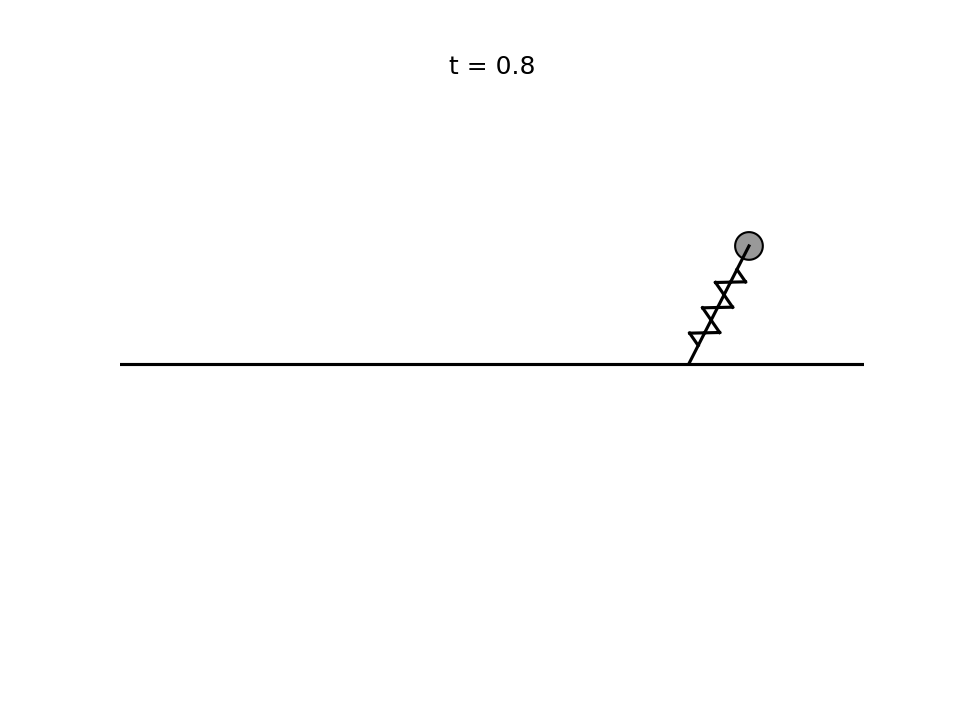

In [12]:
context.get_mutable_continuous_state_vector().SetFromVector(s[:])

duration = 0.8 if get_ipython() else 0.1 # sets a shorter duration during testing
AdvanceToAndVisualize(simulator, visualizer, duration)

# Apex-to-apex map

In [ ]:
plant = SpringLoadedInvertedPendulum()

# Parameters from Geyer05, Figure 2.4
# Note: Geyer uses angle of attack = 90 - touchdown_angle
touchdown_angle = np.deg2rad(30)
Etilde = 1.61

s = SLIPState(np.zeros(8))
s.theta = touchdown_angle
s.r = 1

simulator = Simulator(plant)
context = simulator.get_mutable_context()
context.FixInputPort(0, [touchdown_angle])
context.SetAccuracy(1e-5)

zs = np.linspace(np.cos(touchdown_angle) + 0.001, 0.95, 25)
zns = 0 * zs
for i in range(len(zs)):
    s.z = zs[i]
    s.xdot = plant.apex_velocity_from_dimensionless_system_energy(Etilde, s.z)
    context.SetTime(0.)
    context.get_mutable_continuous_state_vector().SetFromVector(s[:])
    simulator.Initialize()
    # Note: With this duration, I sometimes get an extra "touchdown" after the
    # apex, which results in apex-touchdown; touchdown-takeoff-apex on the
    # console.  It's not a double reset, the consecutive touchdowns are two
    # different sims.
    simulator.AdvanceTo(0.6)
    zns[i] = plant.last_apex
    plant.last_apex = None

fix, ax = plt.subplots()
ax.plot(zs, zns)
ax.plot(zs, zs)
ax.axis("equal")
ax.set_xlim([zs[0], zs[-1]])
ax.set_ylim([zs[0], zs[-1]])
ax.set_xlabel("apex height z[n]")
ax.set_ylabel("apex height z[n+1]")

plt.show()
